<a href="https://colab.research.google.com/github/evan-grinalds/DS-Unit-1-Sprint-1-Data-Wrangling-and-Storytelling/blob/master/module4-logistic-regression/Copy_of_LS_DS17_214_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [62]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [63]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')
df.head(1)

,Location,Burrito,Date,Neighborhood,Address,URL,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,overall,Rec,Reviewer,Notes,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini
0,Donato's taco shop,California,1/18/2016,Miramar,6780 Miramar Rd,http://donatostacoshop.net/,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,3.8,NaN,Scott,good fries: 4/5,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [65]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [66]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [67]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

In [68]:
pd.set_option('display.max_columns', None)

### EDA

In [69]:
df.head(5)

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,1/18/2016,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,1/24/2016,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Carnitas,1/24/2016,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Asada,1/24/2016,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,California,1/27/2016,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [70]:
list(df)

['Burrito',
 'Date',
 'Yelp',
 'Google',
 'Chips',
 'Cost',
 'Hunger',
 'Mass (g)',
 'Density (g/mL)',
 'Length',
 'Circum',
 'Volume',
 'Tortilla',
 'Temp',
 'Meat',
 'Fillings',
 'Meat:filling',
 'Uniformity',
 'Salsa',
 'Synergy',
 'Wrap',
 'Unreliable',
 'NonSD',
 'Beef',
 'Pico',
 'Guac',
 'Cheese',
 'Fries',
 'Sour cream',
 'Pork',
 'Chicken',
 'Shrimp',
 'Fish',
 'Rice',
 'Beans',
 'Lettuce',
 'Tomato',
 'Bell peper',
 'Carrots',
 'Cabbage',
 'Sauce',
 'Salsa.1',
 'Cilantro',
 'Onion',
 'Taquito',
 'Pineapple',
 'Ham',
 'Chile relleno',
 'Nopales',
 'Lobster',
 'Queso',
 'Egg',
 'Mushroom',
 'Bacon',
 'Sushi',
 'Avocado',
 'Corn',
 'Zucchini',
 'Great']

In [71]:
# Format date and time for test/train data

df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
df['Date']

0     2016-01-18
1     2016-01-24
2     2016-01-24
3     2016-01-24
4     2016-01-27
         ...    
418   2019-08-27
419   2019-08-27
420   2019-08-27
421   2019-08-27
422   2019-08-27
Name: Date, Length: 421, dtype: datetime64[ns]

###  Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.

In [72]:
train =  df[(df['Date'] >= '2016-01-01') & (df['Date'] <= '2016-12-31')]
val =  df[(df['Date'] >= '2017-01-01') & (df['Date'] <= '2017-12-31')]
test = df[(df['Date'] >= '2018-01-01') & (df['Date'] <= '2018-12-30')]

train.shape, val.shape, test.shape

((296, 59), (85, 59), (27, 59))

### Begin with baselines for classification.

In [73]:
target = 'Great'
y_train = train[target]
y_train.value_counts(normalize=True)

False    0.591216
True     0.408784
Name: Great, dtype: float64

In [74]:
majority_class = y_train.mode()[0]
y_pred = [majority_class] * len(y_train)
y_pred[:5]

[False, False, False, False, False]

In [75]:
# Training accuracy of predicting majority class baseline
from sklearn.metrics import accuracy_score

accuracy_score(y_train, y_pred)

0.5912162162162162

In [76]:
# Calculate validation

y_val = val[target]
y_pred = [majority_class] * len(y_val)

accuracy_score(y_val, y_pred)

0.5529411764705883

In [77]:
# Looking at features to include

train.describe()

,Yelp,Google,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Queso
count,71.000000,71.000000,291.000000,295.000000,0.0,0.0,175.000000,174.000000,174.000000,296.000000,283.000000,286.000000,295.000000,290.000000,294.000000,276.000000,294.000000,294.000000,0.0
mean,3.897183,4.142254,6.892990,3.441525,NaN,NaN,19.829886,22.042241,0.770920,3.468750,3.706360,3.551573,3.515763,3.529069,3.395238,3.323370,3.537075,3.958163,NaN
std,0.478680,0.371738,1.211763,0.853811,NaN,NaN,2.081275,1.685043,0.137833,0.794864,0.991897,0.863422,0.848306,1.036565,1.091940,0.966205,0.921086,1.164133,NaN
min,2.500000,2.900000,2.990000,0.500000,NaN,NaN,15.000000,17.000000,0.400000,1.400000,1.000000,1.000000,1.000000,0.500000,1.000000,0.000000,1.000000,0.000000,NaN
25%,3.500000,4.000000,6.250000,3.000000,NaN,NaN,18.500000,21.000000,0.662500,3.000000,3.000000,3.000000,3.000000,3.000000,2.500000,2.500000,3.000000,3.500000,NaN
50%,4.000000,4.200000,6.850000,3.500000,NaN,NaN,19.500000,22.000000,0.750000,3.500000,4.000000,3.500000,3.500000,4.000000,3.500000,3.500000,3.750000,4.000000,NaN
75%,4.000000,4.400000,7.500000,4.000000,NaN,NaN,21.000000,23.000000,0.870000,4.000000,4.500000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,NaN
max,4.500000,4.900000,11.950000,5.000000,NaN,NaN,26.000000,27.000000,1.240000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,NaN


### Use scikit-learn for logistic regression and get your model's **validation** accuracy.

In [81]:
# 1. Import estimator class
from sklearn.linear_model import LogisticRegression

# 2. Instantiate this class
log_reg = LogisticRegression(solver='lbfgs')


# 3. Arrange X feature matrices 
features = ['Tortilla',
  'Temp',
  'Meat',
  'Fillings',
  'Meat:filling',
  'Uniformity',
  'Salsa',
  'Synergy',
  'Wrap']

target = 'Great'

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

# Impute missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer()
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)

# 4. Fit the model
log_reg.fit(X_train_imputed, y_train)

# 5. Apply the model to new data.
# The predictions look like this ...
log_reg.predict(X_val_imputed)

array([False, False,  True,  True, False, False,  True,  True, False,
        True,  True, False, False, False,  True, False, False,  True,
        True,  True,  True, False, False, False,  True,  True,  True,
       False,  True,  True,  True, False, False, False, False, False,
        True,  True, False, False, False, False,  True,  True,  True,
        True, False, False,  True, False, False, False,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True,  True,  True, False,  True,  True,
        True,  True, False, False, False,  True,  True,  True,  True,
        True, False,  True,  True])

In [104]:
print('Validation Accuracy', log_reg.score(X_val_imputed, y_val))

Validation Accuracy 0.8470588235294118


### Use scikit-learn for logistic regression and get your model's **test** accuracy.

In [102]:
# 1. Import estimator class
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler

# 2. Instantiate this class

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)

# One-Hot Encoding

encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

# 3. Arrange X feature matrices 

X_test = test[features]
X_test_encoded = encoder.transform(X_test)
X_test_imputed = imputer.transform(X_test_encoded)
X_test_scaled = scaler.transform(X_test_imputed)
y_pred = model.predict(X_test_scaled)

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_val_imputed = imputer.transform(X_val_encoded)

# 4. Fit the model
model = LogisticRegressionCV()
model.fit(X_train_scaled, y_train)

# 5. Apply the model to new data.
# The predictions look like this ...

y_pred = model.predict(X_val_scaled)
accuracy_score(y_val, y_pred)

0.8823529411764706

In [103]:
print('Test Accuracy', model.score(X_val_scaled, y_val))

Test Accuracy 0.8823529411764706


### Stretch Goals

In [ ]:
# Used scaling and one hot encoding on test accuracy 

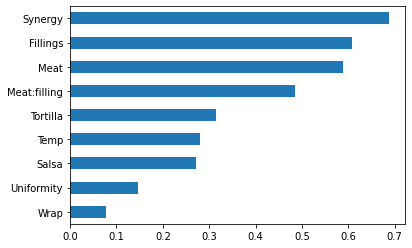

In [99]:
# Get and plot coefficients

%matplotlib inline
coefficients = pd.Series(model.coef_[0], X_train_encoded.columns)
coefficients.sort_values().plot.barh();